In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels import api as sm
import warnings
warnings.filterwarnings('ignore')

# What Makes a Great Football Player?

**By: George Li**

### Introduction
We'll be looking at data about teams in National Football League (NFL). For those of you living under a rock:

The NFL is a professional American football league that consists of 32 teams, divided equally between the American Football Conference and the National Football Conference. The goal of each team is to win as many games out of a 17 game season as possible. Teams win games by scoring more points than their opponents. This can be done in one of five ways:
- Touchdown (six points)
- Field Goal (three points)
- Two-Point Conversion (two points)
- Extra Point (one point)
- Safety (two points)
- For more details: https://www.rookieroad.com/football/how-does-scoring-work/

In principle, better players generally cost more, so teams that want good players need to spend more money. Teams that spend the most, theoretically, should win the most. 

Instead of focusing on what would make an amazing team, lets focus on the players. We will be taking a look at the players in the NFL (from the Madden NFL 21 video game) compare to eachother and to the top 200 players. We will also look at what attributes they possess, and how those attributes contribute to their overall player rating (a measure of hey impactful a player is).

# Data Collection

### Source
The dataset that will be used in this project will contain every NFL player from the 2022 season (2080 players total). Data on the player's attributes (out of 100) and qualitative data are given. We will be looking at a player's position, overall rating, and attributes only for this project.

Dataset found on reddit: [link](reddit.com/r/Madden/comments/ouzjvd/madden_22_player_ratings_spreadsheet_fully/)

Excel Spreadsheet: [link](https://docs.google.com/spreadsheets/d/1vEpaW-_7QlhFPO4UojESKpJWtvPSJL5f/edit#gid=424489096)

More info on a player: [link](https://www.maddenratings.com/tom-brady)

# Data Management

### Loading the Data
Here we just load the .csv file into a dataframe using pandas.

In [21]:
madden = pd.read_csv('madden.csv')
madden.head()

,Unnamed: 0,Player Info,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78
0,#,Team,Position,Archetype,Jersey #,First Name,Last Name,Age,Height,Weight,...,Handedness,College,Portrait ID,Team ID,Primary Key,Full Name,Player Asset,Iteration,Status,BLANK
1,1,Packers,WR,WR_RouteRunner,17,Davante,Adams,28,73,215,...,Right,Fresno State,6328,20,10823,Davante Adams,AdamsDavante_10823,launch-ratings,published,NaN
2,2,Chiefs,QB,QB_Improviser,15,Patrick,Mahomes,25,75,230,...,Right,Texas Tech,8648,9,12635,Patrick Mahomes,MahomesIIPatrick_12635,launch-ratings,published,NaN
3,3,Chiefs,TE,TE_VerticalThreat,87,Travis,Kelce,31,77,260,...,Right,Cincinnati,5920,9,890,Travis Kelce,KelceTravis_890,launch-ratings,published,NaN
4,4,Rams,RE,DE_PowerRusher,99,Aaron,Donald,30,73,280,...,Right,Pittsburgh,6394,24,10852,Aaron Donald,DonaldAaron_10852,launch-ratings,published,NaN


### Reformatting Data
At first glance it is clear that the .csv file was not formatted correctly. This may have been due to some conversion error from .xlsx to .csv or it might have been a formatting issue on the curators part.

Regardless, we must reformat the data so that it can be used.

In [22]:
madden = madden.iloc[: , 1:-1]
new_header = madden.iloc[0] #grab the first row for the header
madden = madden[1:] #take the data less the header row
madden.columns = new_header #set the header row as the df header
madden.head()

,Team,Position,Archetype,Jersey #,First Name,Last Name,Age,Height,Weight,Overall,...,Years Pro,Handedness,College,Portrait ID,Team ID,Primary Key,Full Name,Player Asset,Iteration,Status
1,Packers,WR,WR_RouteRunner,17,Davante,Adams,28,73,215,99,...,7,Right,Fresno State,6328,20,10823,Davante Adams,AdamsDavante_10823,launch-ratings,published
2,Chiefs,QB,QB_Improviser,15,Patrick,Mahomes,25,75,230,99,...,4,Right,Texas Tech,8648,9,12635,Patrick Mahomes,MahomesIIPatrick_12635,launch-ratings,published
3,Chiefs,TE,TE_VerticalThreat,87,Travis,Kelce,31,77,260,99,...,8,Right,Cincinnati,5920,9,890,Travis Kelce,KelceTravis_890,launch-ratings,published
4,Rams,RE,DE_PowerRusher,99,Aaron,Donald,30,73,280,99,...,7,Right,Pittsburgh,6394,24,10852,Aaron Donald,DonaldAaron_10852,launch-ratings,published
5,Rams,CB,CB_MantoMan,5,Jalen,Ramsey,26,73,208,99,...,5,Right,Florida State,8185,24,17538,Jalen Ramsey,RamseyJalen_17538,launch-ratings,published


With a quick peek at the datatypes of each column it can be seen that we need to some further reformating such that we can properly analyze it.

In [23]:
madden.dtypes.unique()

array([dtype('O')], dtype=object)

To do this we will simply map each of the quantitative column data types from 'object' to 'integer'

In [24]:
new_dtype = {}
cols = ['Overall', 'Speed', 'Acceleration',
       'Agility', 'Change of Dir', 'Strength', 'Jumping', 'Awareness',
       'Carrying', 'Break Tackle', 'Juke Move', 'Spin Move', 'Trucking',
       'Stiff Arm', 'BC Vision', 'Catching', 'Catch In Traffic', 'Spec Catch',
       'Release', 'Short RR', 'Medium RR', 'Deep RR', 'Throw Power',
       'Throw Acc Short', 'Throw Acc Mid', 'Throw Acc Deep',
       'Throw Under Pressure', 'Throw On The Run', 'Play Action', 'Break Sack',
       'Run Block', 'Run Block Power', 'Run Block Finesse', 'Pass Block',
       'Pass Block Power', 'Pass Block Finesse', 'Impact Blocking',
       'Lead Blocking', 'Tackle', 'Hit Power', 'Pursuit', 'Man Coverage',
       'Zone Coverage', 'Press', 'Play Recognition', 'Power Moves',
       'Finesse Moves', 'Block Shedding', 'Kick Power', 'Kick Accuracy',
       'Kick Return', 'Stamina', 'Injury', 'Toughness']
for col in cols:
    new_dtype[col] = 'int'

madden = madden.astype(new_dtype)
madden.dtypes.unique()

array([dtype('O'), dtype('int32')], dtype=object)

We can now run whatever analysis we want on this dataset.

### Overview
Here we will take a quick peek at the data that is avaialable to us using the .describe() method using pandas.

In [25]:
madden.describe()

,Overall,Speed,Acceleration,Agility,Change of Dir,Strength,Jumping,Awareness,Carrying,Break Tackle,...,Play Recognition,Power Moves,Finesse Moves,Block Shedding,Kick Power,Kick Accuracy,Kick Return,Stamina,Injury,Toughness
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,...,2080.000000,2080.00000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,71.756731,81.054808,85.929808,78.286058,72.042788,71.958654,80.506731,71.994231,56.542788,41.918750,...,46.495673,35.00625,35.401442,47.472596,22.676923,19.934615,33.506250,83.925000,87.873558,82.790385
std,8.181412,9.817080,5.376617,10.430807,13.614800,12.122758,8.952494,11.246846,17.835821,25.512838,...,26.422402,24.05854,23.326136,19.387624,15.572896,13.208709,26.885591,6.118294,3.704822,7.360392
min,58.000000,50.000000,63.000000,43.000000,33.000000,25.000000,25.000000,46.000000,0.000000,5.000000,...,10.000000,5.00000,5.000000,10.000000,7.000000,6.000000,5.000000,62.000000,70.000000,43.000000
25%,65.000000,74.000000,83.000000,72.000000,60.000000,63.000000,76.000000,63.000000,40.750000,17.000000,...,20.000000,10.00000,10.000000,30.000000,17.000000,13.000000,10.000000,80.000000,86.000000,79.000000
50%,70.000000,84.000000,87.000000,81.000000,75.000000,72.000000,82.000000,71.000000,59.000000,44.000000,...,54.000000,30.00000,35.000000,48.000000,19.000000,17.000000,16.500000,85.000000,88.000000,84.000000
75%,77.000000,89.000000,90.000000,86.000000,83.000000,82.000000,87.000000,80.000000,71.000000,67.000000,...,69.000000,58.00000,56.000000,65.000000,22.000000,21.000000,56.000000,88.000000,90.000000,87.000000
max,99.000000,99.000000,99.000000,98.000000,99.000000,99.000000,99.000000,99.000000,99.000000,98.000000,...,99.000000,99.00000,97.000000,97.000000,99.000000,97.000000,98.000000,99.000000,99.000000,99.000000


# Data Analysis

Basics Analysis:
- The Mean Overall Rating for the players of 2022 is around 72
- The majority of players have an Overall Rating in between 65 and 77

### Player Distribution
Let's take a quick look at the player distribution in the league. For this, we will count the number of rows corresponding to each position.

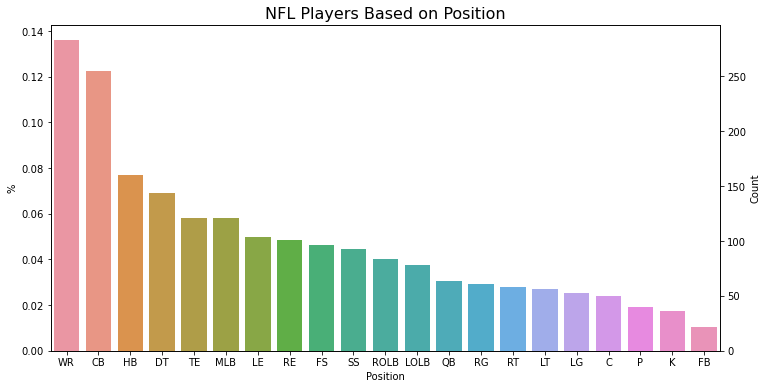

In [26]:
pos_all = madden.groupby('Position')['Position'].size().reset_index(name='Count')
pos_all['%'] = pos_all['Count']/pos_all['Count'].sum()

pos_all_sorted = pos_all.sort_values('Count', ascending=False)

plt.figure(figsize=(12,6))
plt.title("NFL Players Based on Position", fontsize=16)
ax = sns.barplot(data=pos_all_sorted, x='Position', y='%')
ax2 = ax.twinx()
g2 = sns.barplot(data=pos_all_sorted, x= 'Position', y = 'Count', ax = ax2)

plt.show()

At first glance, it seems as if there are a lot more Wide Receivers and Cornerbacks than the rest, while there are very few members of the Special Team (Kickers and Punters). We will look a bit closer later on in this project.

### Rating Distribution
There are a total of 2293 players in the NFL. Let's look at the distribution of rankings amounst these players.

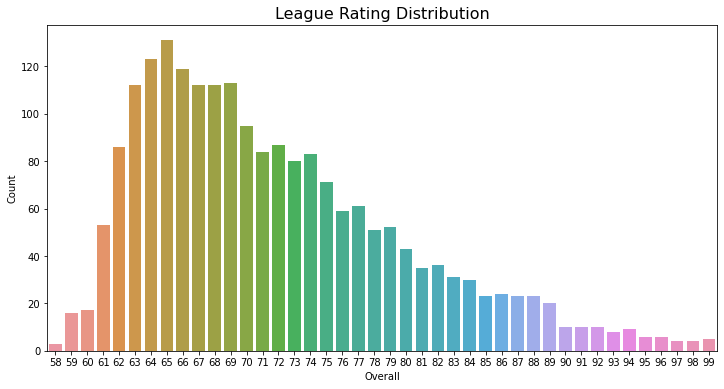

In [37]:
ratings = madden.groupby('Overall')['Overall'].size().reset_index(name='Count')

plt.figure(figsize=(12,6))
plt.title("League Rating Distribution", fontsize=16)
ax2 = sns.barplot(data=ratings, x='Overall', y='Count')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 0)
plt.show()

In [28]:
pos_all['Position'].unique()

array(['C', 'CB', 'DT', 'FB', 'FS', 'HB', 'K', 'LE', 'LG', 'LOLB', 'LT',
       'MLB', 'P', 'QB', 'RE', 'RG', 'ROLB', 'RT', 'SS', 'TE', 'WR'],
      dtype=object)

### Next Steps
For our next few analyses we will split the different positions into different categories:
- Offensive Team
    - (1) Offensive Line (LG, RG, LT, RT, C)
    - (2) Wide Receivers and Tight Ends (WR and TE)
    - (3) Quarterbacks (QB)
    - (4) Half Backs and Fullbacks (HB and FB)
- (5) Defensive Team (DT, LE, RE, MLB, ROLB, LOLB, CB, FS, and SS)
- (6) Speacial Team (K, P)

We will use these categories later on, as they will give us guidence on how to group certain positions. Special thanks to [this](https://www.rookieroad.com/football/positions/#positional-groups) for helping me compile a list of these categories.

In addition, there are so many attributes that we need to take into consideration.

In [29]:
print(cols)
len(cols)

['Overall', 'Speed', 'Acceleration', 'Agility', 'Change of Dir', 'Strength', 'Jumping', 'Awareness', 'Carrying', 'Break Tackle', 'Juke Move', 'Spin Move', 'Trucking', 'Stiff Arm', 'BC Vision', 'Catching', 'Catch In Traffic', 'Spec Catch', 'Release', 'Short RR', 'Medium RR', 'Deep RR', 'Throw Power', 'Throw Acc Short', 'Throw Acc Mid', 'Throw Acc Deep', 'Throw Under Pressure', 'Throw On The Run', 'Play Action', 'Break Sack', 'Run Block', 'Run Block Power', 'Run Block Finesse', 'Pass Block', 'Pass Block Power', 'Pass Block Finesse', 'Impact Blocking', 'Lead Blocking', 'Tackle', 'Hit Power', 'Pursuit', 'Man Coverage', 'Zone Coverage', 'Press', 'Play Recognition', 'Power Moves', 'Finesse Moves', 'Block Shedding', 'Kick Power', 'Kick Accuracy', 'Kick Return', 'Stamina', 'Injury', 'Toughness']


54

Above, we have the columns that represent each different attribute of each player (in addition to the player's overall rating). Clearly there are plenty of attributes to look at, but how should we categorize this?

Luckily, the wonderful developers at EA have already categorized these 53 attributes for us and we will do so as follows:

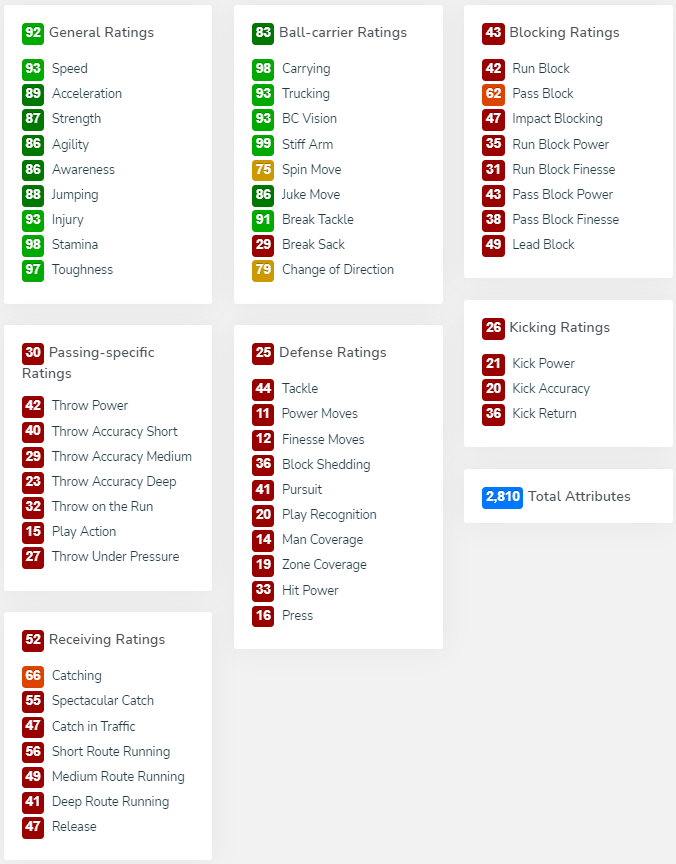

In [30]:
attributes = {}
attributes['General'] = ['Speed', 'Acceleration', 'Agility','Strength', 'Jumping', 'Awareness','Stamina', 'Injury', 'Toughness']
attributes['Carrying'] = ['Change of Dir','Carrying','Break Tackle','Juke Move','Spin Move','Trucking','Stiff Arm', 'BC Vision','Break Sack']
attributes['Blocking'] = ['Run Block', 'Run Block Power', 'Run Block Finesse', 'Pass Block', 'Pass Block Power', 'Pass Block Finesse', 'Impact Blocking', 'Lead Blocking']
attributes['Passing'] = ['Throw Power', 'Throw Acc Short', 'Throw Acc Mid', 'Throw Acc Deep', 'Throw Under Pressure', 'Throw On The Run', 'Play Action']
attributes['Defensive'] = ['Tackle', 'Hit Power', 'Pursuit', 'Man Coverage', 'Zone Coverage', 'Press', 'Play Recognition', 'Power Moves', 'Finesse Moves', 'Block Shedding']
attributes['Kicking'] = ['Kick Power', 'Kick Accuracy', 'Kick Return']
attributes['Recieving'] = ['Catching', 'Catch In Traffic', 'Spec Catch', 'Release', 'Short RR', 'Medium RR', 'Deep RR']

I addition to making these new categories, we will also calculate them for each player. We will do this by taking each category (ie. kick) and then take the average of all their subcategories (ie. 'Kick Power', 'Kick Accuracy', and 'Kick Return').

In [31]:
for att,sub in attributes.items():
    madden[att] = madden[sub].mean(axis=1)
madden.iloc[: , -7:].head()

,Status,General,Blocking,Passing,Defensive,Kicking,Recieving
1,published,89.666667,27.250,16.000000,26.6,33.333333,97.571429
2,published,87.111111,15.375,95.857143,19.3,13.333333,25.714286
3,published,89.666667,66.000,47.857143,23.3,24.333333,88.571429
4,published,90.222222,48.250,9.285714,74.9,18.666667,22.000000
5,published,89.333333,34.500,23.428571,75.8,38.333333,42.428571


Now that we have the overarching attributes all figured out, we will now plot a heat map that represents the correlations between each attribute for each category (group of positions).

### Preliminary Analysis
First we will take a look at how each Attribute Group contributes to a player's Overall Rating for all players.

In [32]:
new_cols = ['First Name', 'Last Name', 'Position','Overall'] + list(attributes.keys())
prelim = madden.copy()[new_cols] # get rid on unneeded columns
prelim.head()

,First Name,Last Name,Position,Overall,General,Carrying,Blocking,Passing,Defensive,Kicking,Recieving
1,Davante,Adams,WR,99,89.666667,75.000000,27.250,16.000000,26.6,33.333333,97.571429
2,Patrick,Mahomes,QB,99,87.111111,72.000000,15.375,95.857143,19.3,13.333333,25.714286
3,Travis,Kelce,TE,99,89.666667,74.666667,66.000,47.857143,23.3,24.333333,88.571429
4,Aaron,Donald,RE,99,90.222222,34.333333,48.250,9.285714,74.9,18.666667,22.000000
5,Jalen,Ramsey,CB,99,89.333333,64.777778,34.500,23.428571,75.8,38.333333,42.428571


Now we will create a dataframe that represents the correlations between the attribute ratings + their overall rating. Then we will sns to plot this onto a heat map.

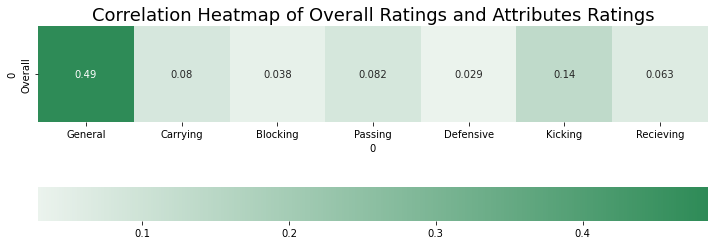

In [36]:
rating_cols = ['Overall'] + list(attributes.keys())
rating_corr_prelim = prelim[rating_cols]
rating_corr_prelim = rating_corr_prelim.corr()
rating_corr_prelim = rating_corr_prelim.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_prelim, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

Looking at the surface, it seems as if there are no attributes (except maybe General Rating) that have any effect on a player's Overall Rating. Note that this is only a correlation heatmap, so we shouldn't draw any conclusions from this just yet.

This is where we can use another piece of data that we are given, a player's position. More specifically, which group the postion belongs in. We can use this to see, at first glance, if there is such a attribute essential to each role in the game. As with the following Position Categories, we will take a closer look at the statistical significance for each of the Attribute Categories and their impact on a player's overal Rating later during our Hypothesis Testing.

We will repeat the process for each position category, but we will skip the explainations as they are the same as above. General comments about the correlations will still be made.

### Offensive Line
Positions:
- Left Guard
- Right Guard
- Left Tackle
- Right Tackle
- Center

We will create a new dataset with those positions included.

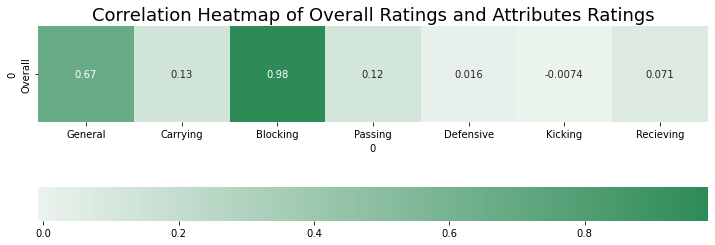

In [34]:
off_line = madden[madden['Position'].isin(['LG', 'RG', 'LT', 'RT', 'C'])]

new_cols = ['First Name', 'Last Name', 'Position','Overall'] + list(attributes.keys())
off_line = off_line[new_cols] # get rid on unneeded columns
rating_corr_off_line = off_line[rating_cols]
rating_corr_off_line = rating_corr_off_line.corr()
rating_corr_off_line = rating_corr_off_line.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_off_line, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that Blocking Rating has a strong correlation to the Overall Rating of a player that plays a position in the Offensive Line. General Rating is also well correlated with Overall Rating but, clearly, not as much.

### Wide Receivers and Tight Ends
Positions:
- Wide Receivers
- Tight Ends

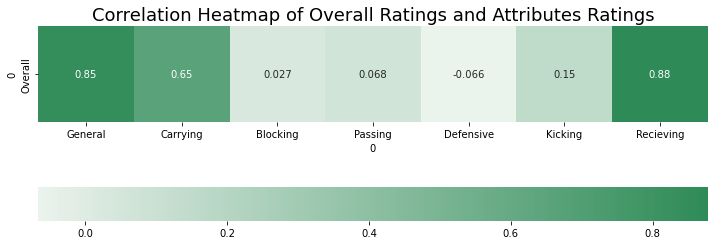

In [19]:
wr_n_te = madden[madden['Position'].isin(['WR', 'TE'])]
wr_n_te = wr_n_te[new_cols] # get rid on unneeded columns
rating_corr_wr_n_te = wr_n_te[rating_cols]
rating_corr_wr_n_te = rating_corr_wr_n_te.corr()
rating_corr_wr_n_te = rating_corr_wr_n_te.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_wr_n_te, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that Recieving Rating has a strong correlation to the Overall Rating of a player that plays Wide Reviever and Tight End. General Rating and Carrying Rating are also well correlated with Overall Rating but, clearly, not as much.

### Quarterbacks
Positions:
- Quarterbacks

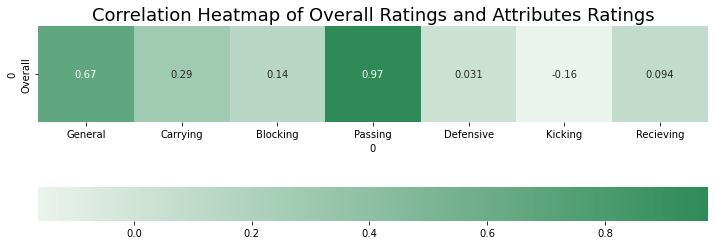

In [20]:
QBs = madden[madden['Position'].isin(['QB'])]

QBs = QBs[new_cols] # get rid on unneeded columns
rating_corr_QB = QBs[rating_cols]
rating_corr_QB = rating_corr_QB.corr()
rating_corr_QB = rating_corr_QB.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_QB, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that Passing Rating has a strong correlation to the Overall Rating of a player that plays Quarterback. General Rating is also well correlated with Overall Rating but, clearly, not as much.

### Half Backs and Fullbacks
Positions:
- Halfbacks
- Fullbacks

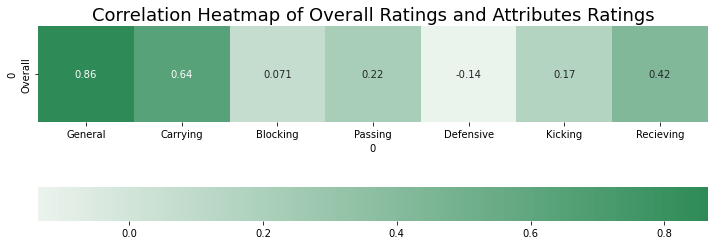

In [21]:
hb_n_fb = madden[madden['Position'].isin(['HB','FB'])]

hb_n_fb = hb_n_fb[new_cols] # get rid on unneeded columns
rating_corr_hb_n_fb = hb_n_fb[rating_cols]
rating_corr_hb_n_fb = rating_corr_hb_n_fb.corr()
rating_corr_hb_n_fb = rating_corr_hb_n_fb.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_hb_n_fb, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that General Rating has a strong correlation to the Overall Rating of a player that plays Halfback or Fullback. Carrying Rating is also well correlated with Overall Rating but, clearly, not as much.

### Defensive Team
Positions:
- Defensive Tackle
- Left Ends
- Right Ends
- Middle Linebackers
- Right Outside Linebacker
- Left Outside Linebacker
- Cornerbacks
- Free Safties
- Safties

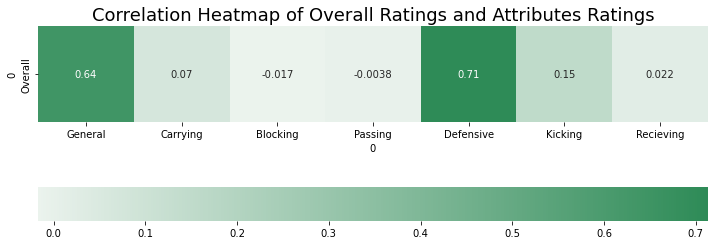

In [22]:
def_team = madden[madden['Position'].isin(['DT','LE','RE','MLB','ROLB', 'LOLB','CB','FS', 'SS'])]

def_team = def_team[new_cols] # get rid on unneeded columns
rating_corr_def_team = def_team[rating_cols]
rating_corr_def_team = rating_corr_def_team.corr()
rating_corr_def_team = rating_corr_def_team.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_def_team, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that Defensive Rating and General Rating has a strong correlation to the Overall Rating of a player that plays for the Defensive Team.

### Special Team
Positions:
- Kickers
- Punters

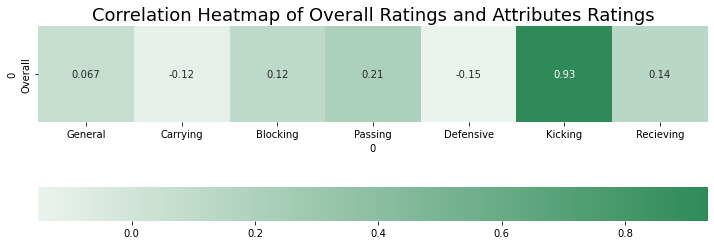

In [23]:
special = madden[madden['Position'].isin(['K','P'])]

special = special[new_cols] # get rid on unneeded columns
rating_corr_special = special[rating_cols]
rating_corr_special = rating_corr_special.corr()
rating_corr_special = rating_corr_special.iloc[:1,1:]
plt.figure(figsize=(12,8))
plt.title("Correlation Heatmap of Overall Ratings and Attributes Ratings", fontsize=18)
sns.heatmap(rating_corr_special, cbar_kws = dict(use_gridspec=False,location="bottom"), cmap=sns.light_palette("seagreen", as_cmap=True), square=True, annot=True)
plt.show()

At face value, it is clear that Kicking Rating has a strong correlation to the Overall Rating of a player that plays on the Special Team. It looks as if nothing else has any impact on a Special Team's Overall Rating.

Now that we have a general idea as to which attributes benefit which roles in the game, let's dive a bit deeper and run some tests.

# Hypothesis Testing

Looking at the 7 different attribute category ratings, we will evaluate the impact of those ratings on a player's Overall Rating.

### Null Hypothesis
We contend that the player's attribute ratings have no statistical influence on a players Overall Rating.

### Testing
Because our distribution is not normal and is right-skewed (Gumbel distribution), we will have to be cautious when selecting a testing method.
Doing this with statsmodel's OLS. 

### Ordinary Least Squares Regression (OLS)
The OLS regression technique is a type of Supervised learning that we will perform on our dataset to try and predict a player's Overall Rating based on one of the 7 position groups we had made earlier: 'General', 'Carrying', 'Blocking', 'Passing', 'Defensive', 'Kicking', and 'Recieving' Ratings. This is done using a regression line generated by this technique.

At the most basic level, the OLS regression technique creates a model that minimizes the sum of the squared errors between the observed data and the predicted one. 

**Note: instead of using the OLS_Model.summary() for each of the roles, we will just pick out the p-values, as they are what is important for our test**

### Variables
We will be testing to see if a player's Overall Rating is dependent on the players's individual Atributes for each role in the game.

### OLS for the Offensive Line

In [24]:
X = off_line[list(attributes.keys())]
y = off_line['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.007
Carrying     0.074
Blocking     0.000
Passing      0.540
Defensive    0.168
Kicking      0.549
Recieving    0.013
dtype: float64

For the Offensive Line, we can reject the null hypothesis. For we can see clearly that there are multiple Attribute Categories that effect an Offensive Lineman's Overall Rating.

In fact, there are 3 Attributes that a player's overall rating is dependent on: General Rating, Blocking Rating, and Recieving Rating. For each of them have a p-value of .05 or less.

Therefore, for the Offensive Line, we can reject the null hypothesis.

### OLS for Wide Receivers and Tight Ends

In [25]:
X = wr_n_te[list(attributes.keys())]
y = wr_n_te['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.000
Carrying     0.003
Blocking     0.000
Passing      0.911
Defensive    0.002
Kicking      0.017
Recieving    0.000
dtype: float64

This time, all but one of the attribute categories (Passing Rating) effect the player's Overall Rating.

Therefore, for Wide Receivers and Tight Ends, we can reject the null hypothesis.

### OLS for the Quarterback

In [26]:
X = QBs[list(attributes.keys())]
y = QBs['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.010
Carrying     0.588
Blocking     0.613
Passing      0.000
Defensive    0.479
Kicking      0.550
Recieving    0.772
dtype: float64

Here, there are 2 Attributes that a player's overall rating is dependent on: General Rating and Passing Rating. For each of them have a p-value of .05 or less.

Therefore, for the Quarterback, we can reject the null hypothesis.

### OLS for Half Backs and Fullbacks

In [27]:
X = hb_n_fb[list(attributes.keys())]
y = hb_n_fb['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.000
Carrying     0.002
Blocking     0.004
Passing      0.013
Defensive    0.078
Kicking      0.067
Recieving    0.001
dtype: float64

Now, there are 5 Attributes that a player's overall rating is dependent on: General Rating, Carrying Rating, Blocking Rating, Passing Rating, and Recieving Rating. For each of them have a p-value of .05 or less.

Therefore, for Half Backs and Fullbacks, we can reject the null hypothesis.

### OLS for the Defensive Team

In [28]:
X = def_team[list(attributes.keys())]
y = def_team['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.000
Carrying     0.000
Blocking     0.001
Passing      0.435
Defensive    0.000
Kicking      0.000
Recieving    0.005
dtype: float64

This time, all but one of the attribute categories (Passing Rating) effect the player's Overall Rating.

Therefore, for the Defensive Team, we can reject the null hypothesis.

### OLS for the Special Team

In [29]:
X = special[list(attributes.keys())]
y = special['Overall']
X = sm.add_constant(X)
# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
round(OLS_model.pvalues, 3)

const        0.000
General      0.590
Carrying     0.296
Blocking     0.393
Passing      0.272
Defensive    0.160
Kicking      0.000
Recieving    0.966
dtype: float64

Finally for the Special Team, just one of the attribute categories (Kicking Rating) effect the player's Overall Rating. This is expected, since they are only on the team to kick the football.

Thus, for the Special Team (and hereby all Position Categories), we can reject the null hypothesis.

### Big Thanks
To the folks over at [Data to Fish](https://datatofish.com/multiple-linear-regression-python/) for their tutorial on how to perform the Linear Regressions above.

# Insights

Comparing each of the heatmaps to their respective linear regression models, we can make some conclusions based on the findings.

### Quarterback and Special Team
- The Quarterback is expected to have an excellent throw (Passing Rating) and should be relatively athletic (General Rating)
- The Special Team is expected to have good kicking skills (Kicking Rating)

For these position categories, what was expected of the groups was met in both the correlation and linear regression models.

### Offensive Line + Halfbacks and Fullbacks
- The Offensive Line is expected to keep the Quarterback safe as long as the ball is still in their hands (Blocking Rating) and should be generally athletic (General Rating)
- The Halfbacks and Fullbacks are expected to have excellent carrying potential (Carrying Rating), decent throwing capabilities (Passing Rating), some catching skills (Receiving Rating) and to be generally athletic (General Rating)

All of these expectations are met by the two groups, but some extra attributes seem to impact a player's overall rating as well. For these groups, they seemingly have one hidden skill that is essential to their roles.

From the linear regression models, it shows that:
- The Offensive Line's catching ability (Receiving Rating) has a statistically significant impact on a the player's Overall Rating
    - This could be due to the fact that there are times where a team knows that their main receivers will be hunted down, and they have no choice but to declare one of their offensive linemen as an eligible reciever
    - At this point, this could be what seperates good offensive linemen from great ones
- The Halfbacks and Fullbacks blocking abilities (Blocking Rating) also play a role in their Overall Ratings
    - This could be due to the fact that one of the Fullback's roles on the field is to act as an extra blocker for the Quarterback

### Wide Receivers and Tight Ends + Defensive Team
- Wide Recievers and Tight Ends are expected to be athletic (General Rating), excellent carriers (Carrying Rating), and exceotional catchers (Receiving Rating)
- The Defensive Team is expected to be strong (General Rating) and have excellent skills at stopping the other team from making plays (Defensive Rating)

While these expectations are certainly met by the players on their respective groups, it takes a lot more than just those generics when it comes to a good player (of those categories). If we take a closer look at the regression models, it shows that both groups need to be extremely versitile and proficient in almost every category.

Now this could be due to one of many things, I will go over two of them.

The first of which is that these positions underrepresent the total player base in the league. Let's take a look. Meaning that there are more players that play these positions than we think.

In [30]:
pos_all[pos_all['Position'].isin(['WR','TE'])].sum()

Position        TEWR
Count            404
%           0.194231
dtype: object

In [31]:
pos_all[pos_all['Position'].isin(['DT','LE','RE','MLB','ROLB', 'LOLB','CB','FS', 'SS'])].sum()

Position    CBDTFSLELOLBMLBREROLBSS
Count                          1076
%                          0.517308
dtype: object

Note that there are 21 positions in Madden 22.

This means that the Wide Receivers and Tight Ends make up a way bigger portion of the overall league than their roles dictate by over 100% (compared to if each position had equal numbers of players). This would explain the vast variety of skills that the players of that position have since the skillsets are spread over a whole variety of players.

If we think about it this makes sense since it is well known that the Wide Receiver is the least important position in NFL. This is because it is very hard to impact the game as a Wide Receiver (unlike the QB), and it is due to the fact that they are the most replacable. Tight Ends are hybrid players, playing both the role of the Offensive Lineman and a Receiver. This would also add to the versatility of this position group.

For the defensive team, we cannot make this same insight (since half of the roles make up about half of the players already). But, since we had grouped together so many players based on their expected traits, we may have overfitted the data (just for the defensive team) to some degree.

### Takeaways
Even so, I think the most important thing derived from this project is that correlations should not be taken as anything but a correlation. For all we know, they might just be coincidences.

Although those correlations did give us a good idea as to what makes a good player (for each position group), the linear regression models revealed that there is more depth than just the correlations. Certain correlations could have canceled eachother out in order to hide special bonuses that a typical player would miss (this would certainly be an impressive feat if it were the case).

But, even so it can be reasonably assumed that a player's Overall Rating was somehow calculated from the 53 attributes given to them by the game developers of Madden. To what degree is each attribute weighted is company secret. Thus, we can only speculate on how the math is done.